In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import utilities # codeTimer context manager and saving/loading utilities.
import data_preparation # Load dataset and build required matrices.
import factorisation # WALS factorisation.
import recommender # Recommender system.

### Loading dataset and creating recommender system

In [4]:
np.random.seed(17)

mov, rat, rat_test = data_preparation.importDataset()
rec = recommender.recommenderSystem(mov, rat, rat_test)
print("Prediction MAE: {}".format(rec.predictionError()))

The dataframe contains 610 users and 9721 items.
Prediction MAE: 46.3893943883063


In [ ]:
# The a pre-trained recommander system can be loaded with the following line.

#utilities.loadRecSys(rec, "rec.npz")

### Explorative analysis

In [5]:
np.count_nonzero(rec.R)
sparsity = np.count_nonzero(rec.R)/np.prod(rec.R.shape)
print("Matrix sparsity: {}%".format(sparsity*100))

Matrix sparsity: 1.5976228580679652%


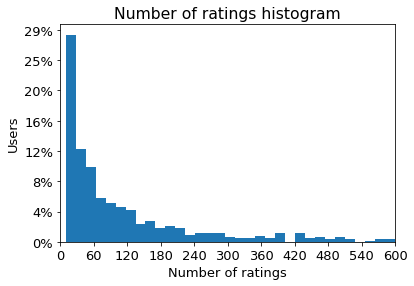

In [6]:
# Distribution of number of ratings.
from matplotlib.ticker import MaxNLocator
plt.rcParams.update({'font.size': 13})

n_ratings = [np.count_nonzero(i) for i in rec.R]


fig, ax = plt.subplots()

ax.hist(n_ratings, bins = 150)

ax.set_title("Number of ratings histogram")
ax.set_ylabel("Users")
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in y_vals/np.shape(rec.R)[0]])
ax.set_xlim(0, 600)
ax.set_xlabel("Number of ratings")
ax.xaxis.set_major_locator(MaxNLocator(integer = True))

plt.savefig("n_ratings.pdf", transparent = True)
plt.show()

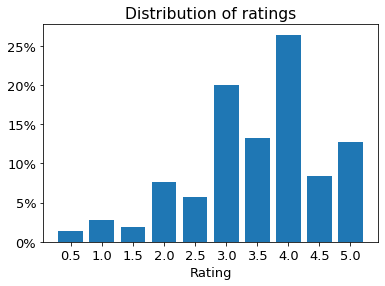

In [7]:
# Counting number ratings.
rates = rec.R.flatten()
rates = rates[rates != 0]
unique, counts = np.unique(rates, return_counts = True)

fig, ax = plt.subplots()
ax.bar(unique, counts / sum(counts), width = 0.4)

ax.set_title("Distribution of ratings")

y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in y_vals])

ax.set_xlabel("Rating")
ax.xaxis.set_major_locator(MaxNLocator(integer = False))
plt.rcParams['xtick.labelsize'] = 11
ax.set_xticks(list(unique))

plt.savefig("ratings_dist.pdf", transparent = True)
plt.show()

### Selecting best regression coefficient with CV

In [ ]:
np.random.seed(17)

reg_lambda = [0.05, 0.15, 0.30]

n_folds = 4
n_iter = 4

# reg_lambda is required to be a list.
with utilities.codeTimer("Best regression lambda CV"):
    best_lambda, errors = rec.bestLambdaCV(n_folds, n_iter, reg_lambda)

In [ ]:
# Plotting results.

fig, ax = plt.subplots()
x = [i + 1 for i in range(n_iter)]
for i in range(len(reg_lambda)):
    ax.plot(x, errors[i][1])

ax.set_title("kFoldCV error")
ax.set_ylabel("MAE")
ax.set_xlabel("Iteration")
ax.xaxis.set_major_locator(MaxNLocator(integer = True))
ax.legend(reg_lambda, title = r"$\lambda$ values")

plt.savefig("TestErrorCV.pdf", transparent = True)
plt.show()

### Factorisation

In [8]:
# Expect ~ 52 min for the execution on the whole dataset with 10 iterations.
#reg_lambda = best_lambda
reg_lambda = 0.15
n_iter = 10

with utilities.codeTimer("WALS factorisation"):
    train, test = rec.performFactorisation(reg_lambda, n_iter)

Performing WALS algoritm...
...Done!
Executed 'WALS factorisation'.  Elapsed time: 3402.041196s


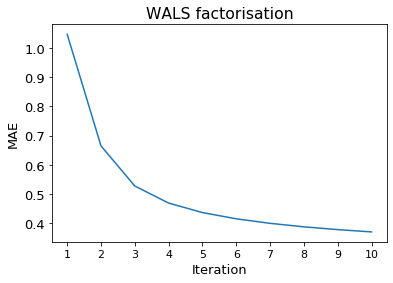

In [9]:
# Plotting results.
fig, ax = plt.subplots()
x = [i + 1 for i in range(len(test))]
ax.plot(x, test)

ax.set_title("WALS factorisation")
ax.set_ylabel("MAE")
#ax.set_ylim(0, 0.9)
ax.set_xlabel("Iteration")
ax.xaxis.set_major_locator(MaxNLocator(integer = True))

plt.savefig("WALS_train.pdf", transparent = True)
plt.show()

In [10]:
# Once the recommender has been trained, it can be saved with the
# following line.

#utilities.saveRecSys(rec, "rec.npz")

### Recommendation

In [ ]:
def recommend(rec_system, user_id):
    return rec_system.answerQuery(user_id)
        
def bestRated(rec_system, user_id):
    user_movies = rec_system.getUserMovies(user_id)
    return user_movies.sort_values(by = "Rating", ascending = False)

In [ ]:
user_id = 2
recommend(rec, user_id).head(10)

In [ ]:
bestRated(rec, user_id).head(10)

### Similar items
Some suggestions:
* 911: Star Wars Episode VI
* 4638: The Lord of the Rings: The Fellowship of the Ring
* 957: The Shining
* 474: Blade Runner

In [ ]:
rec.suggestSimilar(911)

### New user recommendation

In [ ]:
np.random.seed(17)

new_user, new_user_id = rec.generateNewUser(130)
np.shape(rec.R)

In [ ]:
new_user_id

In [ ]:
with utilities.codeTimer("New user factorisation"):
    rec.addNewUser(new_user, reg_lambda)
np.shape(rec.R)

In [ ]:
recommend(rec, new_user_id).head(10)

In [ ]:
bestRated(rec, new_user_id).head(10)

### Cold start problem
If a new user has rated less than 10 movies, the most popular and unseen movies will be recommended.

In [ ]:
np.random.seed(17)

new_user, new_user_id = rec.generateNewUser(8)
np.shape(rec.R)

with utilities.codeTimer("New user factorisation"):
    rec.addNewUser(new_user, reg_lambda)

In [ ]:
recommend(rec, new_user_id).head(10)